In [1]:
# !pip install googlemaps
# !pip install gmplot

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import googlemaps
# import gmplot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

# 00. Load the Dataset

In [4]:
dataset = pd.read_csv("../dataset.csv")
dataset.head(10)

,id,name,address,governate,area,lat,lng,services
0,a2ecf0ba-d4c5-46ab-b013-1090b84d6d98,Abu Al Matamir,Alexandria St. in front of Abo Almatamir Youth...,Al-Behera,Abu Al Matamir,30.912211,30.170589,Withdrawal
1,ccc384e5-1685-4e11-8714-0ebb44713258,Abu Al Matamir,Mohamed Metwally Alshaarawy St. - Abo Almatamir,Al-Behera,Abu Al Matamir,30.910789,30.177019,Withdrawal -Deposit – Forex
2,dd5110e3-dec0-478b-8749-f7f63515d1b3,Abu Al Matamir,The Village of Ten Thousand - Abu Almatamir,Al-Behera,Abu Al Matamir,30.814059,29.988302,Withdrawal -Deposit – Forex
3,f4cce849-681b-4404-9feb-e54bb1cfe134,Abu Al Matamir,Abo Almatamir - Beheira,Al-Behera,Abu Al Matamir,30.915840,30.176447,Withdrawal
4,dc9b6f97-4044-4e0d-970c-2404b5f847dc,Higher Institute of Administrative Scie. Janaklis,Abo Almatamir - Albuhiera,Al-Behera,Abu Al Matamir,30.860114,30.154931,سحب فقط\n
5,e28fec03-c68d-44f5-9504-3a50bea39697,Etsalat - Almostaqbal Franchiez -Abo Almatamir,Abo Almatamir Alhaiar Bridge,Al-Behera,Abu Al Matamir,30.906353,30.173687,سحب فقط\n
6,52b01e68-47a2-4c8d-9d99-115b042a55b5,Etsalat Albehera,Abo Almatamir Almarkaz St.,Al-Behera,Abu Al Matamir,30.911589,30.177179,سحب فقط\n
7,7948b63e-518c-4f8c-b56e-4023246d47ad,Abo Almatamir Health Administration,Alexandria St. in front of Abo Almatamir Youth...,Al-Behera,Abu Al Matamir,30.912211,30.170589,Cash Dispenser only\n
8,c707718c-1080-45c3-95f0-c16897bf151f,Abu Almatamir Central Hospital,Abo Almatamir - Beheira,Al-Behera,Abu Al Matamir,30.915840,30.176447,Cash Dispenser only\n
9,035f3bfe-ad27-4300-8319-22305c065bbc,Tamwely Abu El Matamir,"General Secondary St. Abu El Matamir Center, n...",Al-Behera,Abu Al Matamir,30.912904,30.176892,"withdrawal,deposit"


In [5]:
df = dataset.copy()

# 01: Check Dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4379 entries, 0 to 4378
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4379 non-null   object 
 1   name       4370 non-null   object 
 2   address    4367 non-null   object 
 3   governate  4379 non-null   object 
 4   area       4379 non-null   object 
 5   lat        4379 non-null   float64
 6   lng        4379 non-null   float64
 7   services   4322 non-null   object 
dtypes: float64(2), object(6)
memory usage: 273.8+ KB


In [7]:
grouped_by_gov = df.groupby(['governate']).count()['area'].reset_index().sort_values(by='area',ascending=False)
grouped_by_gov

,governate,area
11,Cairo,1080
14,Giza,538
7,Alexandria,342
12,Dakahlia,252
5,Al-Sharkia,191
0,Al-Behera,167
21,Qalioubia,156
24,Sohag,156
4,Al-Monoufia,152
23,Red Sea,144


In [8]:
grouped_by_area = df.groupby(['area']).count()['id'].reset_index().sort_values(by='id',ascending=False)
grouped_by_area

,area,id
264,Nasr City,171
2,6th of October City,106
267,New Cairo,104
212,Hurghada,98
214,Ismailia,81
...,...,...
296,Sedy Abd Alrahmn,1
33,Al Farfarah,1
111,Bani Suef elgadida,1
27,Akhtab,1


# 02. Handling missing values and Nulls

In [9]:
miss_values = {
    'withdraw':1,
    'withdraw only ':1,
    'Withdraw ':1,
    'Withdraw': 1,
    'Cash Dispenser only\r\n\r\n':1,
    'Cash Dispenser only':1,
    'Cash Dispenser only\n\n': 1,
    'withdrawal ':1,
    'cash withdrawal':1,
    'cash withdraw': 1,
    'سحب فقط':1,
    'withdrawal':1,
    'withdraw only':1,
    'سحب فقط ':1,
    'Withdrawal only' : 1,
    'with drawal': 1,
    'Withdrawal': 1,
    'سحب ':1,
    'سحب': 1,
    'Withdrawal Only': 1,
    'withdrawal only': 1,
    'سحب فقط\r\n':1,
    'سحب فقط\n':1,
    'withdrawal only ':1,
    'Cash Dispenser only\r\n':1,
    'Withdrawl only':1,
    'withdrawl only':1,
    'deposit , withdrawal':2,
    'with drawal deposit':2,
    'deposit,withdrawal':2,
    'withdrawal.deposit':2,
    'withdrawal and deposit':2,
    'withdrawal, deposit':2,
    'سحب وايداع ':2,
    'deposit':2,
    'Cash Dispenser only\n': 2,
    'WIth drawal , deposit':2,
    'Withdrawal and Deposit':2,
    'withdrawal,depsoit':2,
    'withdrawal ,deposit':2,
    'withdrawal , deposit':2,
    'with drawal , deposit':2,
    'withdrawal deposit':2,
    'withdrawal . deposit':2,
    'deposits,withdrawal':2,
    'Withdrawal and Deposit ':2,
    'deposit and withdrawal':2,
    'withdrawal,deposit':2,
    'withdrawal,deposit ':2,
    'depositand withdrawal':2,
    'سحب وايداع': 2,
    '25.142973,34.840527\n\n': 2,
    'deposit withdrawal':2,
    'withdrawal forex deposit':3,
    'withdrawal,deposit,forex':3,
    'withdrawal,forex,deposit':3,
    'withdrawal deposit forex':3,
    'with drawal deposit forex':3,
    'withdrawal forex deposit ':3,
    'withdrawal , forex , deposit':3,
    'Withdrawal -Deposit – Forex':3,
    'Withdrawal, Deposit, Exchange':3,
    'سحب وايداع وتغيير عملة':3,
    'سحب - إيداع - تغيير عملة\n': 3,
    'Withdrawal, deposit and exchange':3,
    'Withdraw - Deposit - Currency Exchange ':3,
    'GBRU سحب - إيداع - تغيير عملة - صرف من الإيداعات\r\n':3,
    'Withdrawal -Deposit - Forex':3,
    'سحب - إيداع - تغيير عملة\r\n':3,
    'سحب - إيداع - تغيير عملة - صرف من الإيداعات GBRU\r\n':3,
    'سحب - إيداع - تغيير عملة - صرف من الإيداعات GBRU\n':3,
    'deposit,withdraw and exchange':3,
    'Withdrawal, Deposit and Exchange':3,
    'withdrawal , forex , deposits':3,
    'with drawal,cash ,forex':3,
    'withdrawal, deposit, forex':3,
    'withdrawal, deposit and exchange':3,
    'Exchange':3,
    'Exchange ':3,
    'withdrawal,forex deposit':3,
    'withdrawal, deposit and exchange\r\n':3,
    'Withdraw - Deposit - Change currency':3,
    'Withdrawal - deposit - currency exchange':3,
    'deposit, withdraw and exchange\t\t\t\t\r\n\t\t\t\t\r\n':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n\t\t\t':3,
    'withdrawal.deposit,forex':3,
    'withdrawal , deposit, forex':3,
    'forex withdrawal deposit':3,
    'forex,deposit,withdrawal':3,
    'forex,withdrawal,deposit':3,
    'withdrawal ,forex ,deposit':3,
    ' Withdrawal, Deposit, Exchange':3,
    'cash withdraw, deposit and exchange':3,
    'سحب - إيداع - تغيير عملة - صرف من الإيداعات GBRU+ Barcode\r\n':3,
    'Withdrawal - Deposit - Change Currency':3,
    'Withdrawal - Exchange - Deposit':3,
    'deposit,withdrawal,forex':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n\t\t\t\t':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n\t\t\t\r\n':3,
    '8:30 AM - 3:00PM\r\n\r\nWithdrawal, Deposit, Exchange':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n\r\n\t\t\t\t\r\n':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\r\n':3,
    'cash withdraw, deposit and exchange\t\r\n':3,
    'GBRU سحب - إيداع - تغيير عملة - صرف من الإيداعات':3,
    'Withdraw - Deposit - Change Currency':3,
    '8:30 AM - 3:00 PM\r\n\r\nWithdrawal -Deposit - Forex':3,
    'forex deposit withdrawal':3,
    'from 8.30 AM to 3 PM\r\n\r\nWithdrawal - deposit - currency exchange':3,
    'Withdraws -Deposits- Forex':3,
    'withdraw, deposit and exchange\t\t\r\n':3,
    'Withdrawal-Deposit-Exchange':3,
    'Withdraw - Deposit - Exchange':3,
    'cash withdraw, deposit and exchange\t\r\n\t\r\n':3,
    'cash withdraw, deposit and exchange\t\t\t\t\r\n':3,
    'Withdraw - Deposit - Exchange Currency':3,
    'Withdrawal, Deposit, Exchange\r\n\r\n':3,
    'Withdrawal, Deposit, Exchange\r\n':3,
    'withdrawal-deposit-currency exchange':3,
    'Withrdrawal, Deposit, Foriegn currency exchange':3,
    'Withdrawal, deposit and exchange':3,
    'withdraw, deposit and exchange\t\t\n': 3,
    'GBRU سحب - إيداع - تغيير عملة - صرف من الإيداعات\n': 3,
    'withdrawal, deposit and exchange\n': 3,

    'Full Function\r\n':3,
    'full function':3,
    'full function ':3,
    'Full Function':3,
    'Full Function\r\n\r\n':3,
    '8 to 5':3,
    '8am-5pm':3,
    '8 am to 5 pm':3,
    '8:300 - 3:00\r\n':3,
    '8:300 - 3:00\n': 3,
    'ATM CENTER\r\n':3,
    '25.142973,34.840527\r\n\r\n':3,
    'Full Function\n': 3,
    'Full Function\n\n': 3,
    'Withdrawal, Deposit, Exchange\n\n': 3,
    'Withdrawal, Deposit, Exchange\n': 3,
    'Withdraw - Deposit - Currency Exchange': 3,
    'from 8.30 AM to 3 PM\n\nWithdrawal - deposit - currency exchange': 3,
    'سحب - إيداع - تغيير عملة - صرف من الإيداعات GBRU+ Barcode\n': 3,
    '8:30 AM - 3:00 PM\n\nWithdrawal -Deposit - Forex': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n': 3,
    'cash withdraw, deposit and exchange\t\n': 3,
    'cash withdraw, deposit and exchange\t\n\t\n': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n': 3,
    '8:30 AM - 3:00PM\n\nWithdrawal, Deposit, Exchange': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\t\n\n\t\t\t\t\n': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n\t\t\t\t': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n\t\t\t\n': 3,
    'deposit, withdraw and exchange\t\t\t\t\n\t\t\t\t\n': 3,
    'cash withdraw, deposit and exchange\t\t\t\t\n\t\t\t': 3,
    'ATM CENTER\n': 3,

}
df['services'] = df['services'].map(lambda x: miss_values[x] if x in miss_values.keys() else x)
df["services"] = df["services"].fillna(2.)

In [10]:
df["services"].value_counts()

1.0    2201
3.0    1462
2.0     716
Name: services, dtype: int64

* Withdrawal: 1
* withdrawal-deposit:2
* Withdrawal-Deposit-Exchange: 3

null: 57 \
1.0  :  2201 \
3.0  :  1462 \
2.0  :   659 \

In [11]:
df = df.drop(columns=["id", "name", "address"])
df

,governate,area,lat,lng,services
0,Al-Behera,Abu Al Matamir,30.912211,30.170589,1.0
1,Al-Behera,Abu Al Matamir,30.910789,30.177019,3.0
2,Al-Behera,Abu Al Matamir,30.814059,29.988302,3.0
3,Al-Behera,Abu Al Matamir,30.915840,30.176447,1.0
4,Al-Behera,Abu Al Matamir,30.860114,30.154931,1.0
...,...,...,...,...,...
4374,Suez,Suez,29.967446,32.550833,3.0
4375,Suez,Suez,29.967901,32.553257,2.0
4376,Suez,Suez,29.975812,32.546986,2.0
4377,Suez,Suez,29.970363,32.551087,3.0


# 03. Visualize

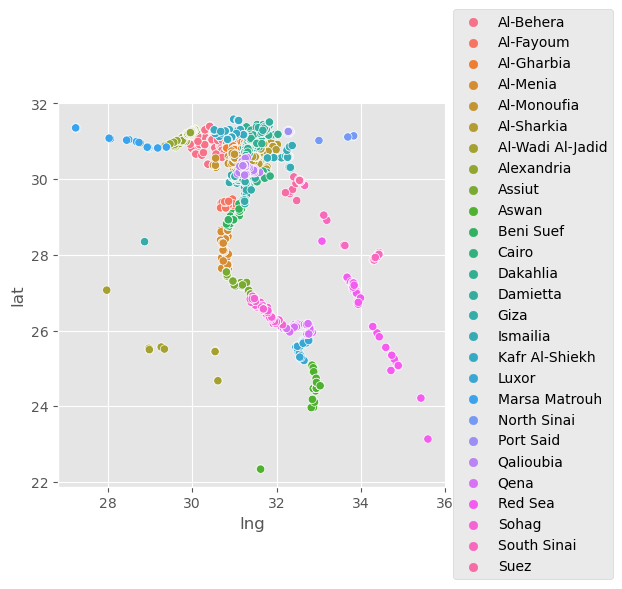

In [12]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="lng", y="lat", hue="governate")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.show();

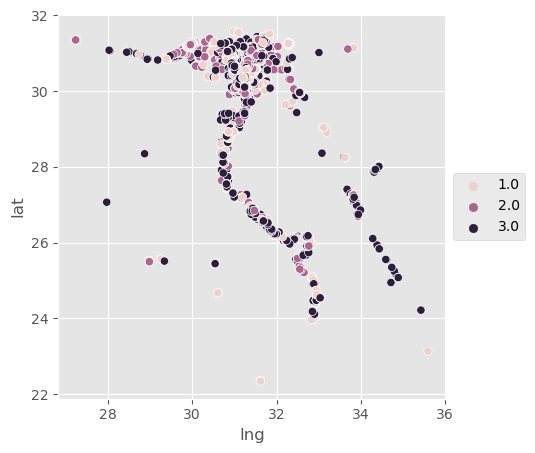

In [13]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="lng", y="lat", hue="services")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.show();

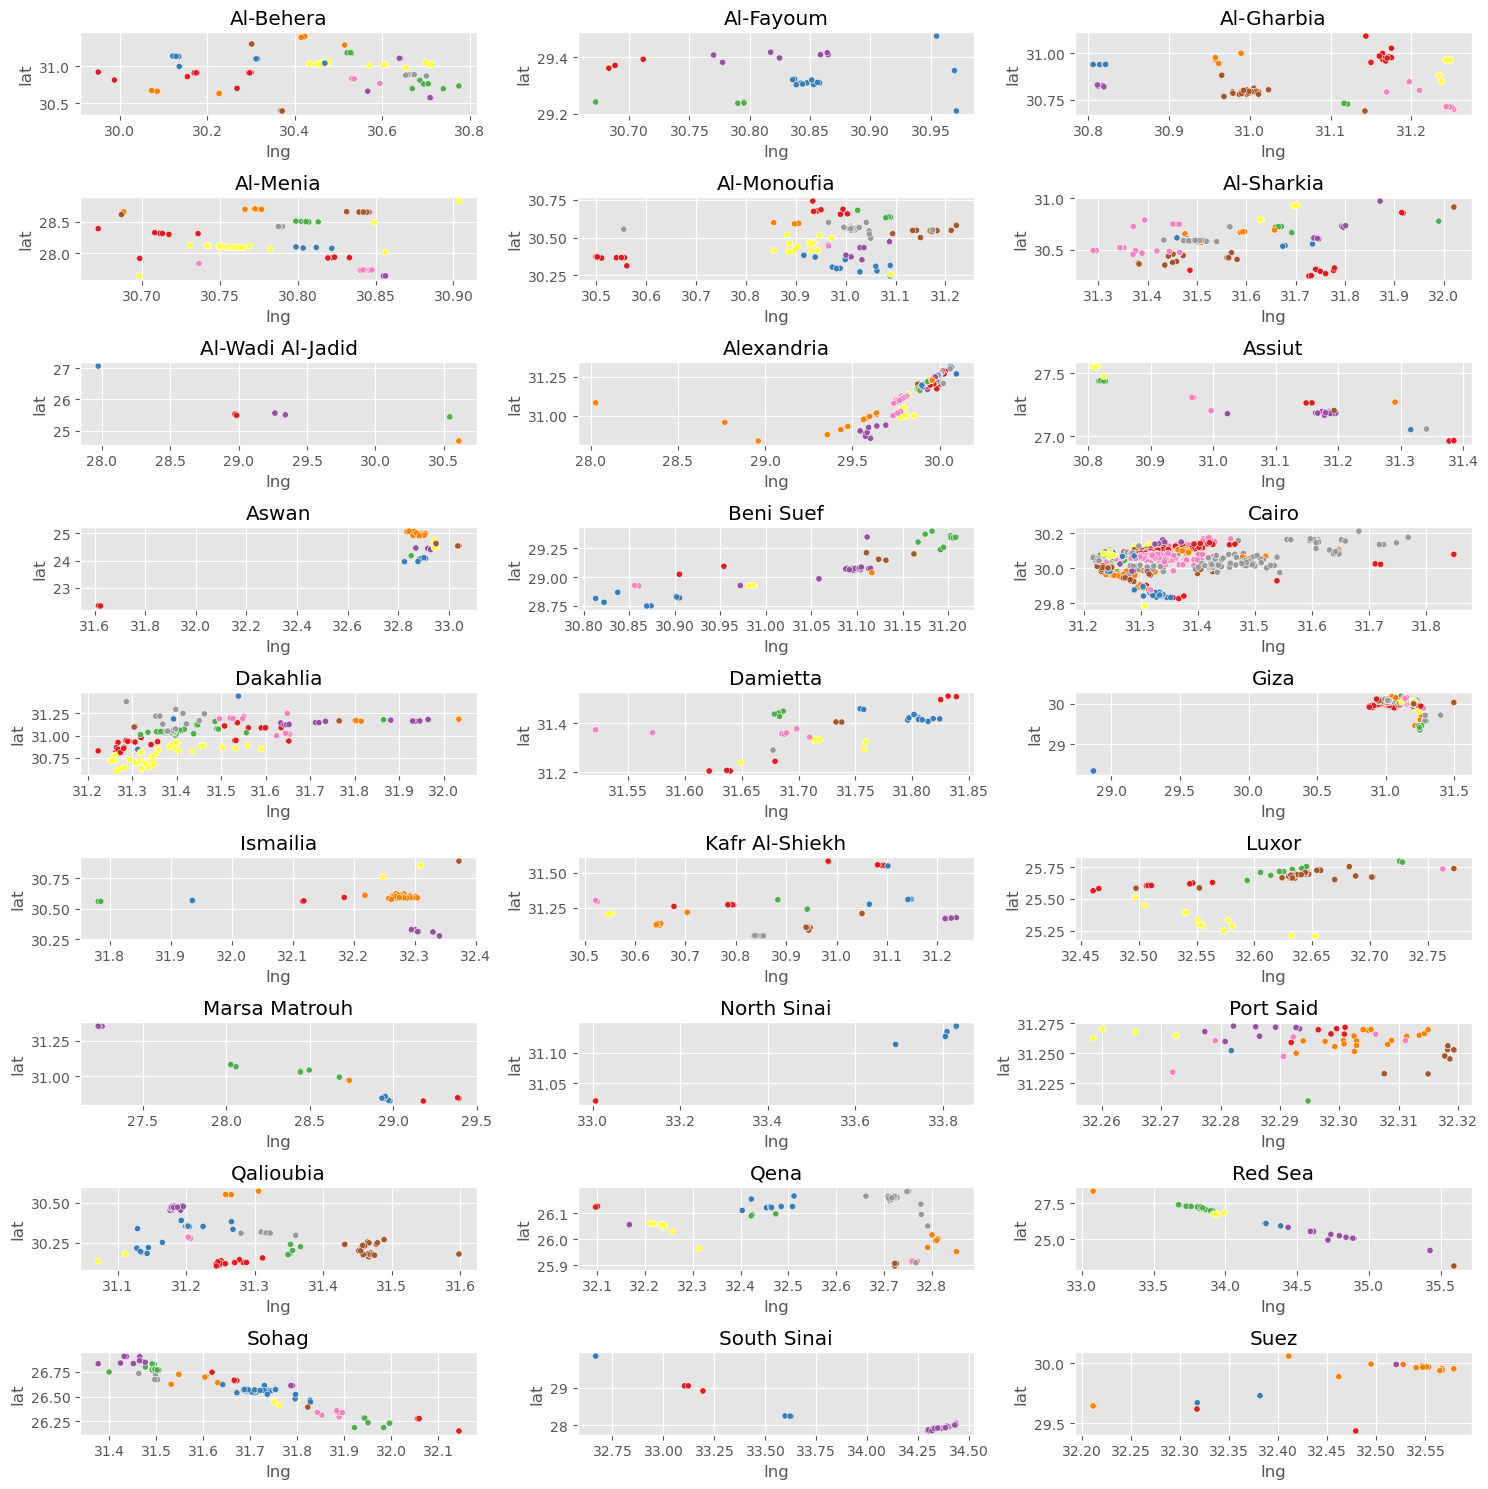

In [14]:
# Unique governorates in your DataFrame
unique_governorates = df['governate'].unique()
num_governorates = len(unique_governorates)

# Calculate the number of rows and columns for subplots
num_cols = 3  # You can adjust the number of columns as needed
num_rows = int(np.ceil(num_governorates / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate through unique governorates and plot each one
for i, governorate in enumerate(unique_governorates):
    ax = axes[i]
    ax.set_title(governorate)
    sns.scatterplot(
        x=df[df['governate'] == governorate]['lng'],
        y=df[df['governate'] == governorate]['lat'],
        hue=df[df['governate'] == governorate]['area'],
        palette='Set1',
        legend=None,
        ax=ax,
        s=20,  # Adjust the size of the points as needed
    )

# Hide any remaining empty subplots
for i in range(num_governorates, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

# 04. The Models

In [15]:
df

,governate,area,lat,lng,services
0,Al-Behera,Abu Al Matamir,30.912211,30.170589,1.0
1,Al-Behera,Abu Al Matamir,30.910789,30.177019,3.0
2,Al-Behera,Abu Al Matamir,30.814059,29.988302,3.0
3,Al-Behera,Abu Al Matamir,30.915840,30.176447,1.0
4,Al-Behera,Abu Al Matamir,30.860114,30.154931,1.0
...,...,...,...,...,...
4374,Suez,Suez,29.967446,32.550833,3.0
4375,Suez,Suez,29.967901,32.553257,2.0
4376,Suez,Suez,29.975812,32.546986,2.0
4377,Suez,Suez,29.970363,32.551087,3.0


## 04.The Model

## 04.01: THe K-Mean with clustring by lat and lng (27 clusters)

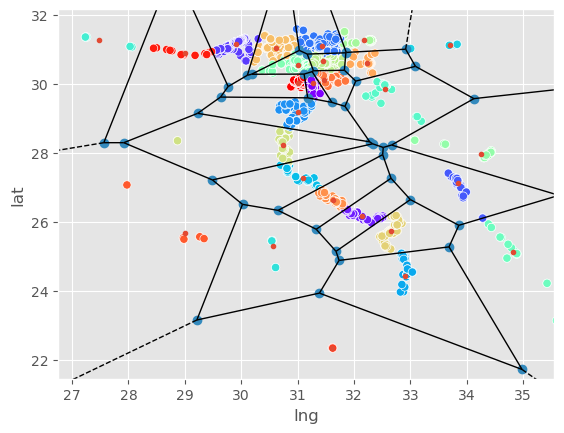

In [16]:
kmeans = KMeans(n_clusters=27)
kmeans.fit(df[['lng','lat',  ]])
cluster = kmeans.predict(df[['lng','lat', ]])
sns.scatterplot(x=df['lng'],y=df['lat'],hue=cluster,palette='rainbow',legend=None)

centers=kmeans.cluster_centers_
vor = Voronoi(centers)
fig = voronoi_plot_2d(vor,plt.gca())

plt.show()

## 04.02 K-mean and Grouping by Governate and cluster each Governate with lat and lng.

In [17]:
dict_governate = \
{
    'Cairo': 10,
    'Giza': 10,
    'Alexandria': 10,
    'Qalioubia': 8,
    'Al-Behera': 5,
    'Dakahlia': 6,
    'Port Said': 6,
    'Al-Monoufia': 5,
    'Damietta': 5,
    'Al-Menia': 4,
    'Al-Sharkia': 4,
    'Assiut': 4,
    'Beni Suef': 4,
    'Ismailia': 4,
    'Kafr Al-Shiekh': 4,
    'Luxor': 4,
    'Sohag': 4,
    'Suez': 4,
    'Al-Fayoum': 3,
    'Al-Gharbia': 3,
    'Qena': 3,
    'South Sinai': 3,
    'Marsa Matrouh': 2,
    'Al-Wadi Al-Jadid': 2,
    'Aswan': 2,
    'North Sinai': 2,
    'Red Sea': 2,
}

### 04.02.01: Cairo

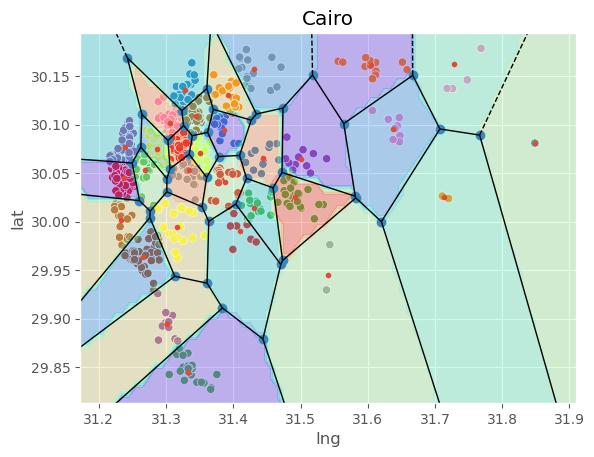

In [18]:
df_cairo = df.loc[df['governate'] == 'Cairo']
kmeans_cairo = KMeans(n_clusters=30)
kmeans_cairo.fit(df_cairo[['lng','lat']])
cluster_cairo = kmeans_cairo.predict(df_cairo[['lng','lat']])

plt.title("Cairo")
sns.scatterplot(x=df_cairo['lng'], y=df_cairo['lat'], hue=cluster_cairo,palette='Set1', legend=None)

x_min, x_max = df['lng'].min() - 1, df['lng'].max() + 1
y_min, y_max = df['lat'].min() - 1, df['lat'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = kmeans_cairo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.3)

centers_cairo=kmeans_cairo.cluster_centers_
vor = Voronoi(centers_cairo)
fig = voronoi_plot_2d(vor,plt.gca())

plt.show()

In [19]:
df_cairo["cluster_cairo"] = cluster_cairo
df_cairo

,governate,area,lat,lng,services,cluster_cairo
1402,Cairo,15th of May City,29.828746,31.367421,3.0,2
1403,Cairo,15th of May City,29.842563,31.375574,1.0,2
1404,Cairo,15th of May City,29.827338,31.366390,3.0,2
1405,Cairo,15th of May City,29.833806,31.356309,3.0,2
1406,Cairo,15th of May City,29.903439,31.309506,3.0,21
...,...,...,...,...,...,...
2477,Cairo,Zamalek,30.041969,31.224798,1.0,0
2478,Cairo,Zamalek,30.050740,31.226001,2.0,0
2479,Cairo,Zamalek,30.057156,31.225345,3.0,0
2480,Cairo,Zamalek,30.047390,31.223963,2.0,0


In [20]:
# df_cairo["area"].nunique()
# df_cairo["area"].value_counts().reset_index()


In [21]:
cluster_15 = df_cairo.loc[df_cairo["cluster_cairo"] == 15, ["area", "lat", "lng"]]
cluster_15.head(3)

,area,lat,lng
1498,Ain Shams,30.094296,31.344778
1502,Ain Shams,30.125515,31.349041
1504,Ain Shams,30.114244,31.333264


In [22]:
coordinates = cluster_15[['lng', 'lat']].values
names = cluster_15['area'].values

In [23]:
import routingpy as rp

In [24]:
key_api = "22971884-a597-4f70-b55b-930feb3bde02"

In [25]:
# api_key = # get a free key at https://www.graphhopper.com/
api = rp.Graphhopper(api_key=key_api)
matrix = api.matrix(locations=coordinates, profile='car')
durations = np.matrix(matrix.durations)
print(durations)

[[  0 570 418 ... 254 266 275]
 [822   0 323 ... 682 694 703]
 [636 487   0 ... 834 846 855]
 ...
 [595 662 731 ...   0  13  22]
 [604 671 740 ... 280   0   9]
 [595 662 732 ... 272 284   0]]


In [26]:
def symmetricize(m, high_int=None):

    # if high_int not provided, make it equal to 10 times the max value:
    if high_int is None:
        high_int = round(10*m.max())

    m_bar = m.copy()
    np.fill_diagonal(m_bar, 0)
    u = np.matrix(np.ones(m.shape) * high_int)
    np.fill_diagonal(u, 0)
    m_symm_top = np.concatenate((u, np.transpose(m_bar)), axis=1)
    m_symm_bottom = np.concatenate((m_bar, u), axis=1)
    m_symm = np.concatenate((m_symm_top, m_symm_bottom), axis=0)

    return m_symm.astype(int) # Concorde requires integer weights

In [27]:
symmetricize(durations)

matrix([[    0, 15560, 15560, ...,   595,   604,   595],
        [15560,     0, 15560, ...,   662,   671,   662],
        [15560, 15560,     0, ...,   731,   740,   732],
        ...,
        [  595,   662,   731, ...,     0, 15560, 15560],
        [  604,   671,   740, ..., 15560,     0, 15560],
        [  595,   662,   732, ..., 15560, 15560,     0]])

In [28]:
# from concorde.problem import Problem
# from concorde.concorde import Concorde

# def solve_concorde(matrix):
#     problem = Problem.from_matrix(matrix)
#     solver = Concorde()
#     solution = solver.solve(problem)
#     print(f'Optimal tour: {solution.tour}')
#     return solution

In [29]:
# # Set your Google Maps API key here
# api_key = key_api

# # Create a Google Maps client
# gmaps = googlemaps.Client(key=api_key)



# # Maximum number of waypoints allowed per request (excluding origin and destination)
# max_waypoints_per_request = 25

# # Iterate over unique clusters in df_cairo
# for cluster_label in df_cairo['cluster_cairo'].unique():
#     # Filter the DataFrame for the current cluster
#     cluster_df = df_cairo[df_cairo['cluster_cairo'] == cluster_label]

#     # Extract coordinates and colors
#     coordinates = cluster_df[['lat', 'lng']].values.tolist()
#     colors = ['red' if i == 0 else 'blue' for i in range(len(coordinates))]

#     # Split the coordinates into batches of max_waypoints_per_request
#     coordinate_batches = [coordinates[i:i + max_waypoints_per_request] for i in range(0, len(coordinates), max_waypoints_per_request)]

#     for batch_idx, batch_coordinates in enumerate(coordinate_batches):
#         # Request directions for the current batch
#         waypoints = batch_coordinates[1:-1]  # Exclude the starting and ending points
#         directions_result = gmaps.directions(
#             origin=batch_coordinates[0],  # Starting point
#             destination=batch_coordinates[-1],  # Ending point
#             waypoints=waypoints,  # Other points
#             optimize_waypoints=True,  # Optimize the route
#             mode='driving',  # You can specify 'driving', 'walking', or 'bicycling'
#         )

#         # Extract the optimized route details
#         route = directions_result[0]['legs'][0]

#         # Create a gmplot instance centered at the starting point of the current batch
#         start_lat, start_lng = batch_coordinates[0]
#         gmap = gmplot.GoogleMapPlotter(start_lat, start_lng, 10)

#         # Plot the optimized route
#         latitudes = [step['start_location']['lat'] for step in route['steps']]
#         longitudes = [step['start_location']['lng'] for step in route['steps']]
#         gmap.plot(latitudes, longitudes, 'blue', edge_width=5)

#         # Add markers for all points
#         for i, (lat, lng, color) in enumerate(zip(latitudes, longitudes, colors)):
#             if i == 0:
#                 title = 'Start'
#             else:
#                 title = f'Point {i}'
#             gmap.marker(lat, lng, color=color, title=title)

#         # Save the map as an HTML file with a meaningful name (e.g., cluster_1_batch_0_map.html)
#         output_filename = f'cluster_{cluster_label}_batch_{batch_idx}_map.html'
#         gmap.draw(output_filename)